# EDAとCatBoostによる学習

CatBoostでの学習が遅いため、Kaggle Notebook上でGPUを用いて学習している。 <br>
コードはここで書かれているものとあまり変わらない。

### 参考文献
* https://www.kaggle.com/code/darkdevil18/0-97596-subscribe-or-not-no-blend#Model-Training

### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

sns.set_theme(style="whitegrid", palette="husl")
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

### import Data

In [2]:
train = pd.read_csv('../data/inputs/train.csv', index_col='id')
test = pd.read_csv('../data/inputs/test.csv', index_col='id')

In [3]:
train.info()
train.head()

<class 'pandas.core.frame.DataFrame'>
Index: 750000 entries, 0 to 749999
Data columns (total 17 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   age        750000 non-null  int64 
 1   job        750000 non-null  object
 2   marital    750000 non-null  object
 3   education  750000 non-null  object
 4   default    750000 non-null  object
 5   balance    750000 non-null  int64 
 6   housing    750000 non-null  object
 7   loan       750000 non-null  object
 8   contact    750000 non-null  object
 9   day        750000 non-null  int64 
 10  month      750000 non-null  object
 11  duration   750000 non-null  int64 
 12  campaign   750000 non-null  int64 
 13  pdays      750000 non-null  int64 
 14  previous   750000 non-null  int64 
 15  poutcome   750000 non-null  object
 16  y          750000 non-null  int64 
dtypes: int64(8), object(9)
memory usage: 103.0+ MB


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
id,,,,,,,,,,,,,,,,,
0,42,technician,married,secondary,no,7,no,no,cellular,25,aug,117,3,-1,0,unknown,0
1,38,blue-collar,married,secondary,no,514,no,no,unknown,18,jun,185,1,-1,0,unknown,0
2,36,blue-collar,married,secondary,no,602,yes,no,unknown,14,may,111,2,-1,0,unknown,0
3,27,student,single,secondary,no,34,yes,no,unknown,28,may,10,2,-1,0,unknown,0
4,26,technician,married,secondary,no,889,yes,no,cellular,3,feb,902,1,-1,0,unknown,1


欠損値は初めから存在していない。

## Exploratory Data Analysis

In [4]:
def custom_describe(df):
    df_ = df.select_dtypes(include=np.number)
    des = df_.describe().T
    des['skewness'] = df_.skew()
    des['kurtosis'] = df_.kurtosis()
    des['count'] = des['count'].astype(int)
    return des

In [5]:
features = test.columns.tolist()
print(features)

['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome']


In [6]:
numerical_features = train.select_dtypes(include=np.number).columns.tolist()
categorical_features = train.select_dtypes(exclude=np.number).columns.tolist()
target = 'y'

In [7]:
print(numerical_features)
print(categorical_features)

['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous', 'y']
['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']


### Target Analysis

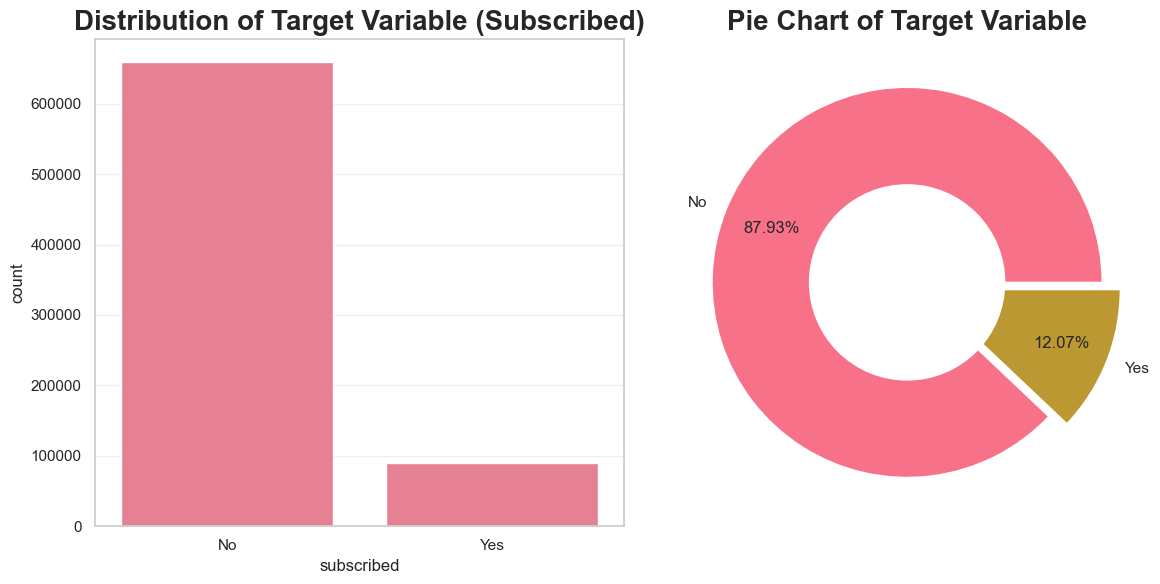

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sns.countplot(x=target, data=train, ax=axes[0])
axes[0].set_title('Distribution of Target Variable (Subscribed)', fontweight='bold', size=20)
axes[0].set_xticks(ticks=[0, 1],labels=['No', 'Yes'])
axes[0].set_xlabel("subscribed")

train[target].value_counts().plot(kind='pie', ax=axes[1], explode=(0.0, 0.1), autopct="%.2f%%", labels=['No', 'Yes'], pctdistance=0.75)
axes[1].add_artist(plt.Circle((0, 0), 0.5, fc='w'))
axes[1].set_title('Pie Chart of Target Variable', fontweight='bold', size=20)
axes[1].set_ylabel("")

plt.tight_layout()
plt.show()

### Numerical Feature Analysis

In [9]:
custom_describe(train[numerical_features])

,count,mean,std,min,25%,50%,75%,max,skewness,kurtosis
age,750000,40.926395,10.098829,18.0,33.0,39.0,48.0,95.0,0.586137,-0.069561
balance,750000,1204.067397,2836.096759,-8019.0,0.0,634.0,1390.0,99717.0,12.304123,268.863623
day,750000,16.117209,8.250832,1.0,9.0,17.0,21.0,31.0,0.054014,-1.044458
duration,750000,256.229144,272.555662,1.0,91.0,133.0,361.0,4918.0,2.048776,6.434523
campaign,750000,2.577008,2.718514,1.0,1.0,2.0,3.0,63.0,4.810437,37.493557
pdays,750000,22.412733,77.319998,-1.0,-1.0,-1.0,-1.0,871.0,3.625049,13.597849
previous,750000,0.298545,1.335926,0.0,0.0,0.0,0.0,200.0,13.749885,820.304755
y,750000,0.120651,0.325721,0.0,0.0,0.0,0.0,1.0,2.329296,3.425627


In [10]:
def numerical_features_plot(df, feature, target):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle(f'Analysis of {feature}', fontweight='bold', size=16)

    #Boxplot
    sns.boxplot(x=feature, y=target, data=df, hue=target, ax=axes[0], orient='h')
    axes[0].set_title(f'Boxplot of {feature}')
    axes[0].legend_.remove()

    # Violin plot
    sns.violinplot(x=feature, y=target, data=df, hue=target, ax=axes[1], orient='h')
    axes[1].set_title(f'Violin Plot of {feature}')
    axes[1].legend_.remove()

    # Histogram
    sns.histplot(data=df, x=feature, hue=target, kde=True, ax=axes[2], alpha=0.6)
    axes[2].set_title(f'Histogram of {feature}')
    axes[2].legend_.remove()

    plt.tight_layout()
    plt.show()

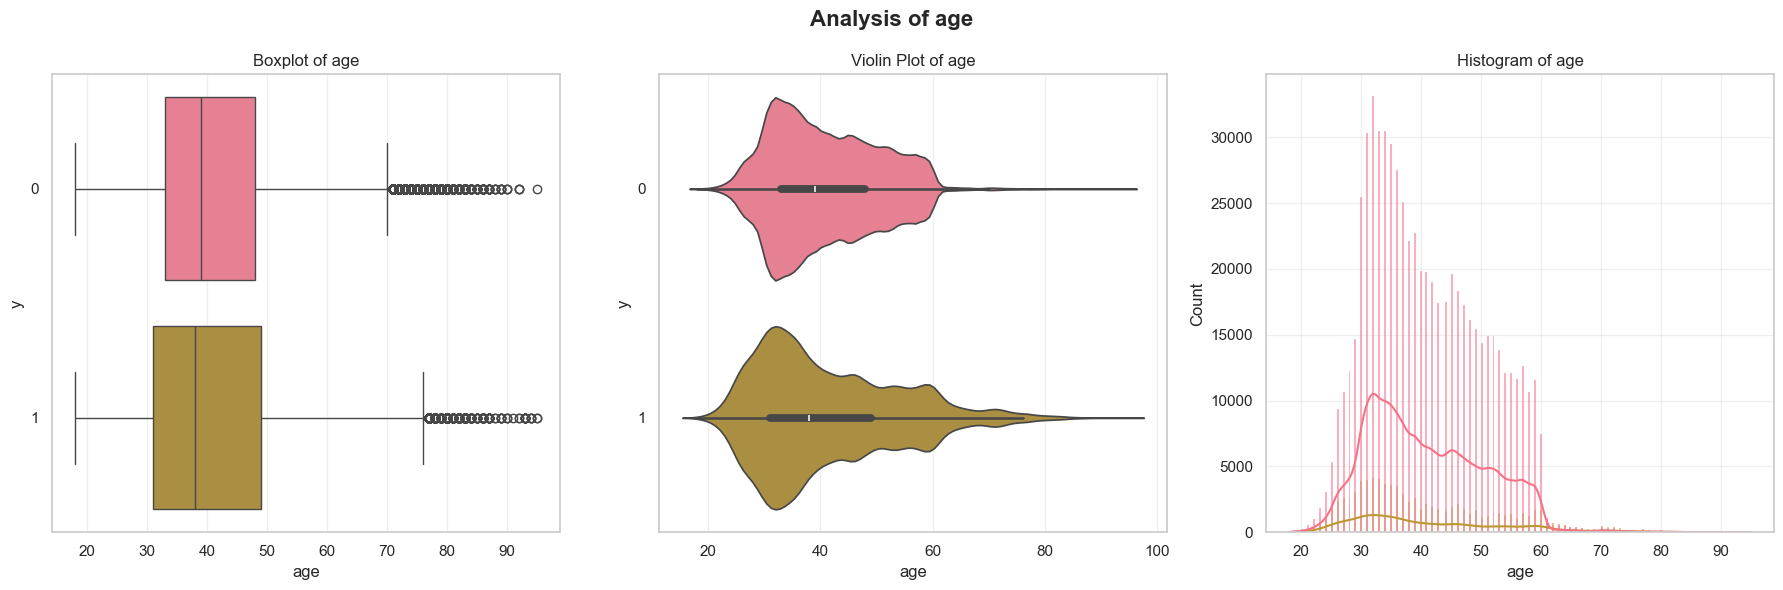

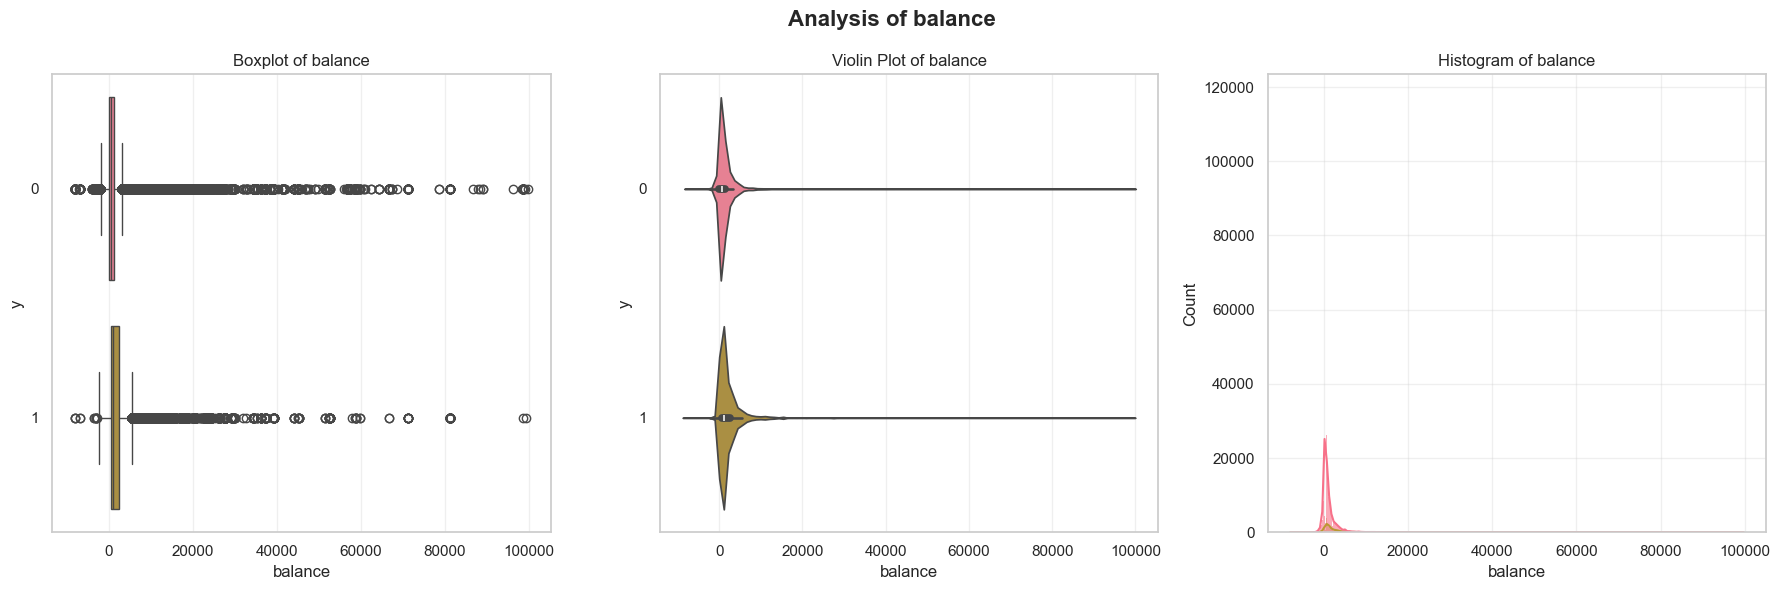

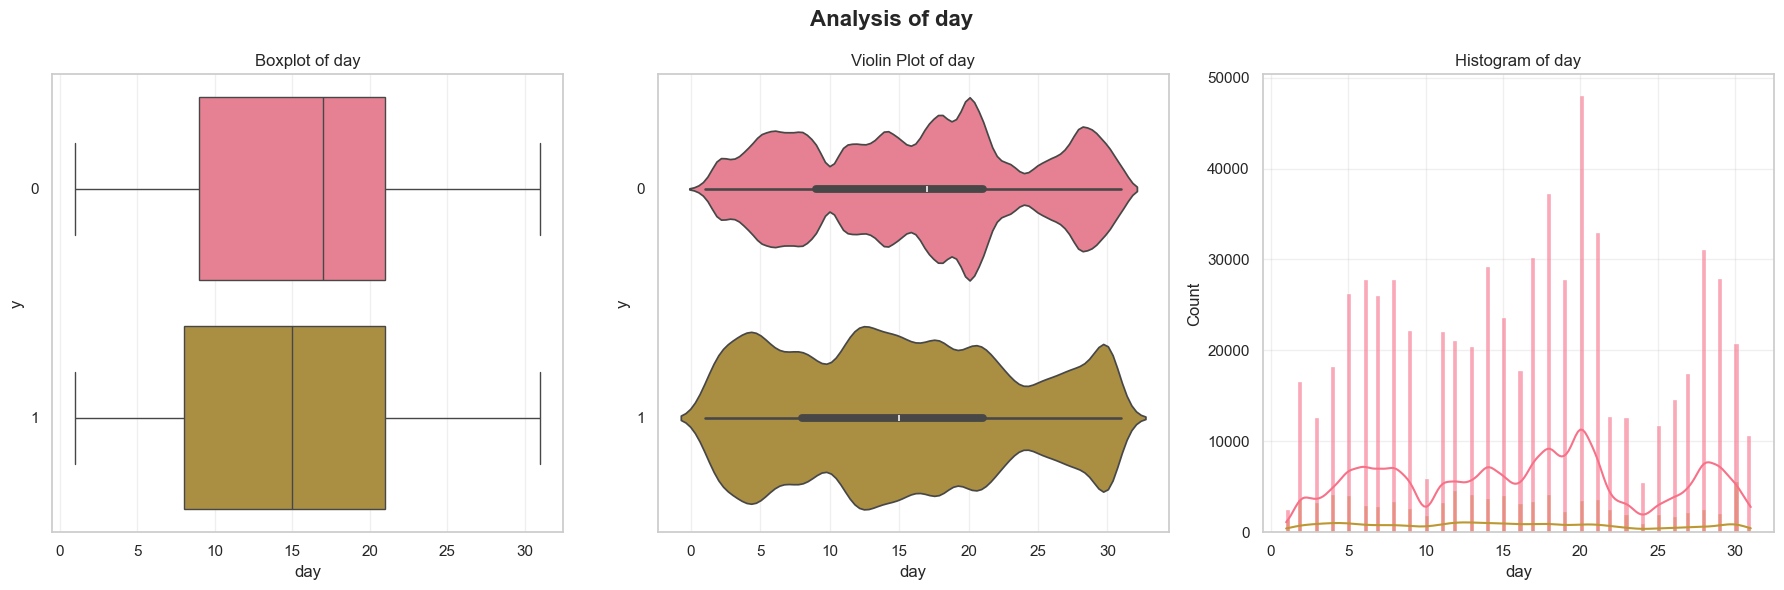

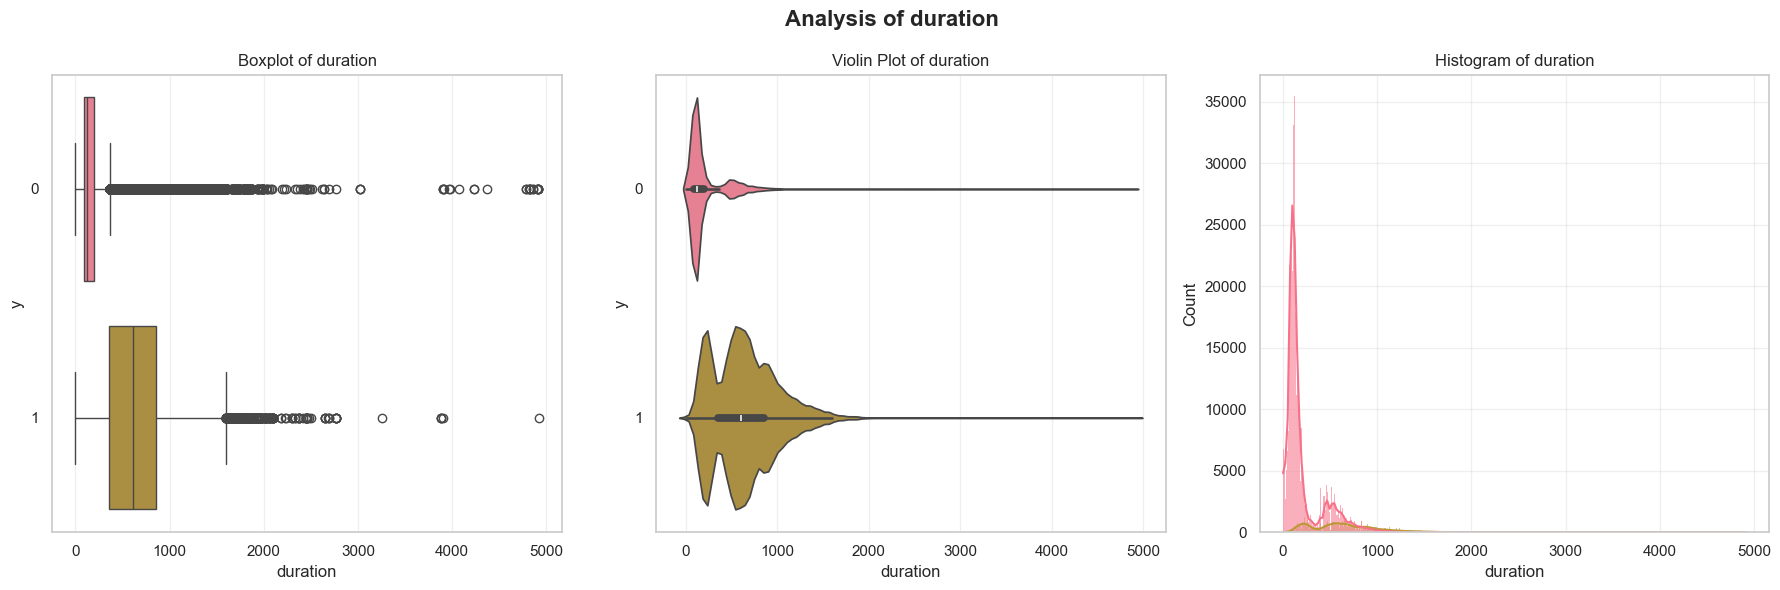

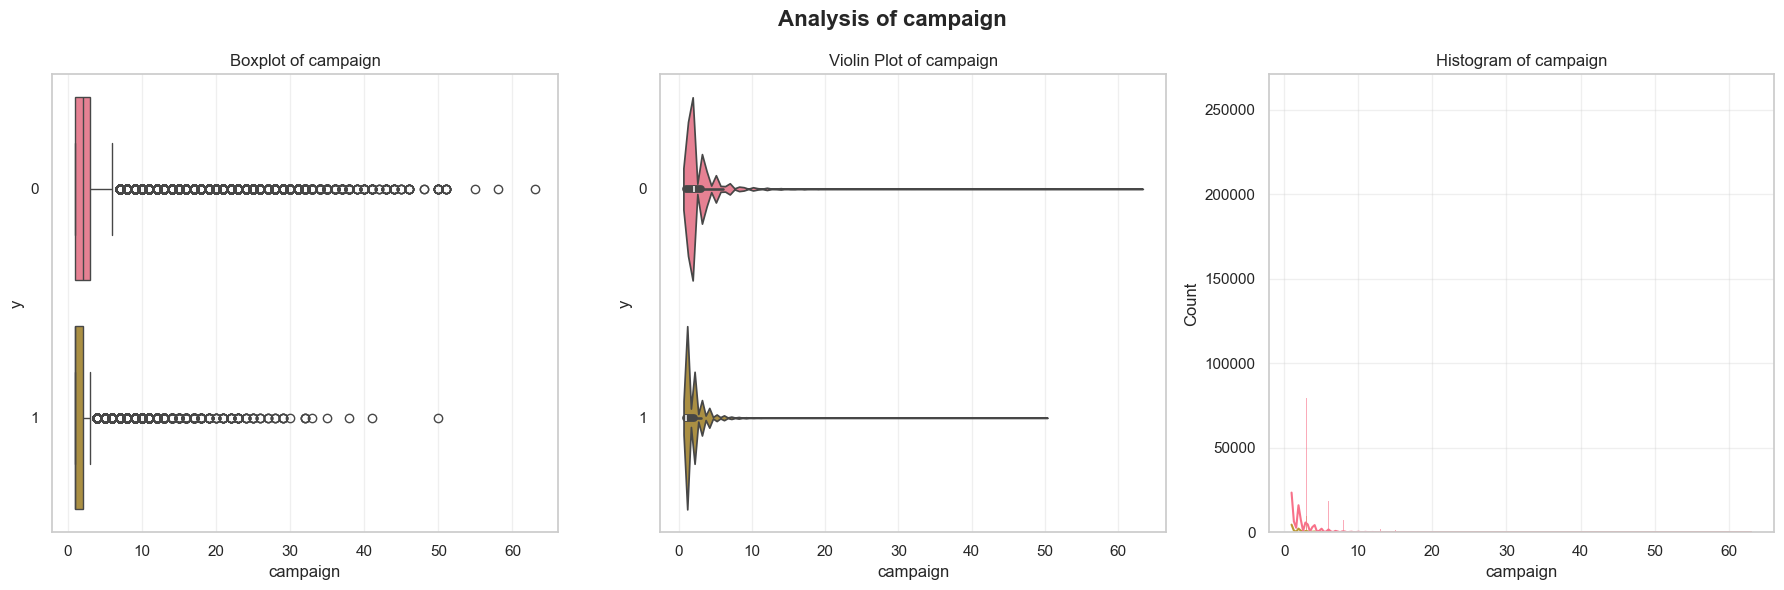

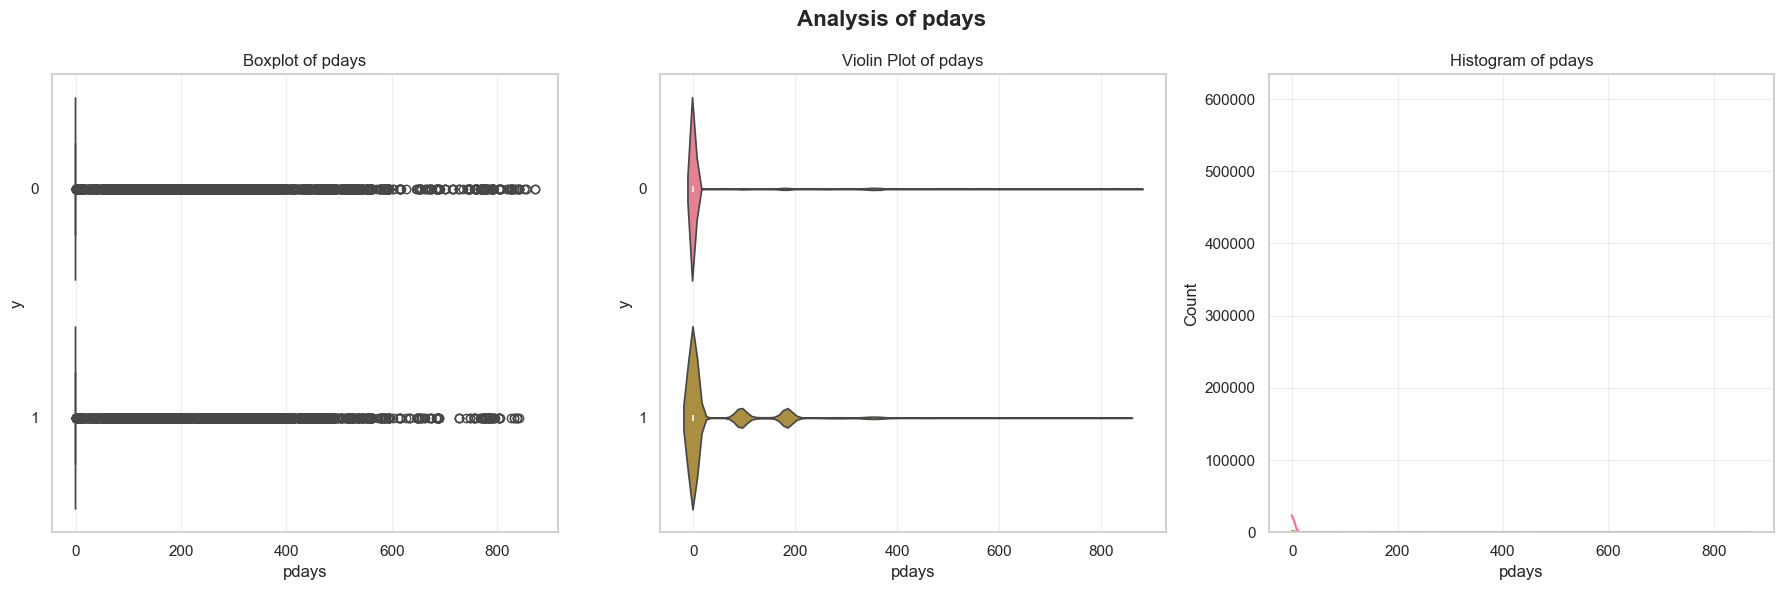

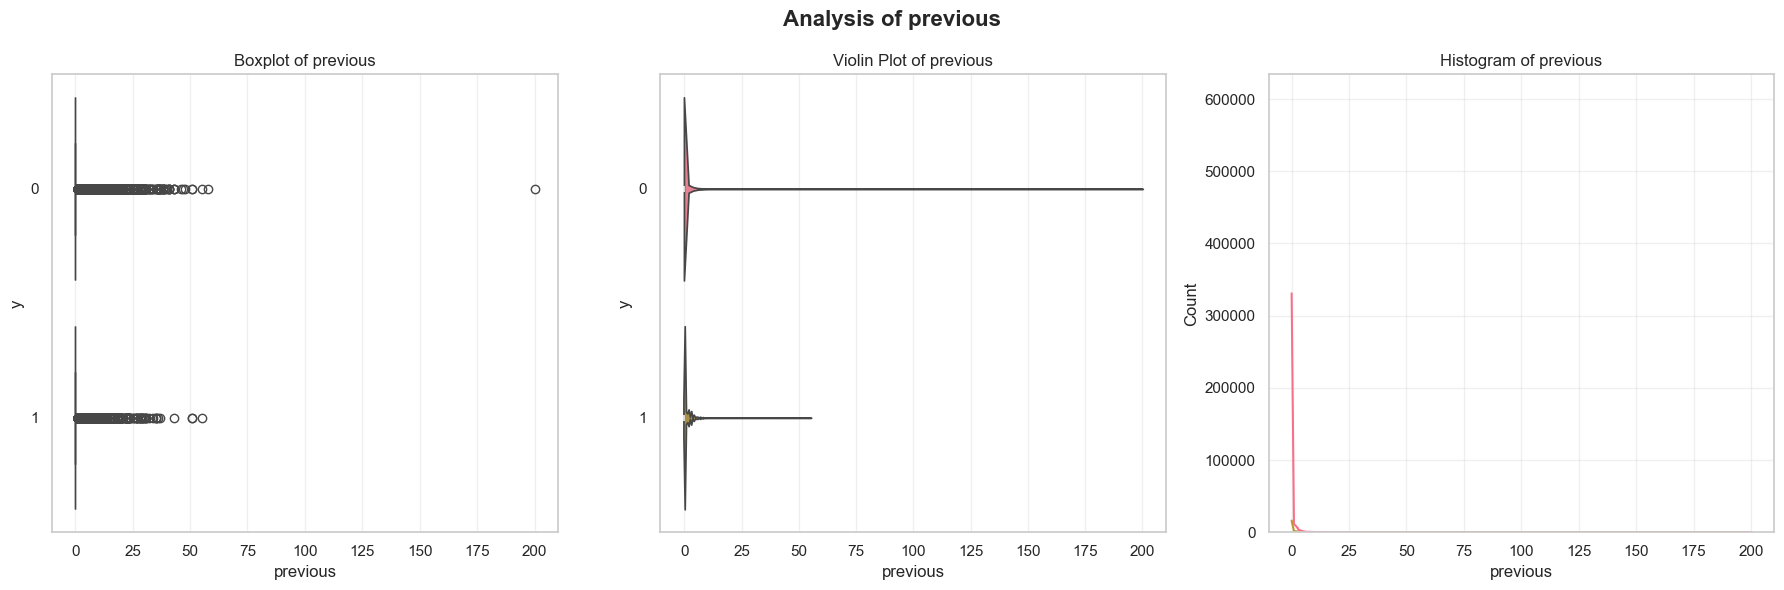

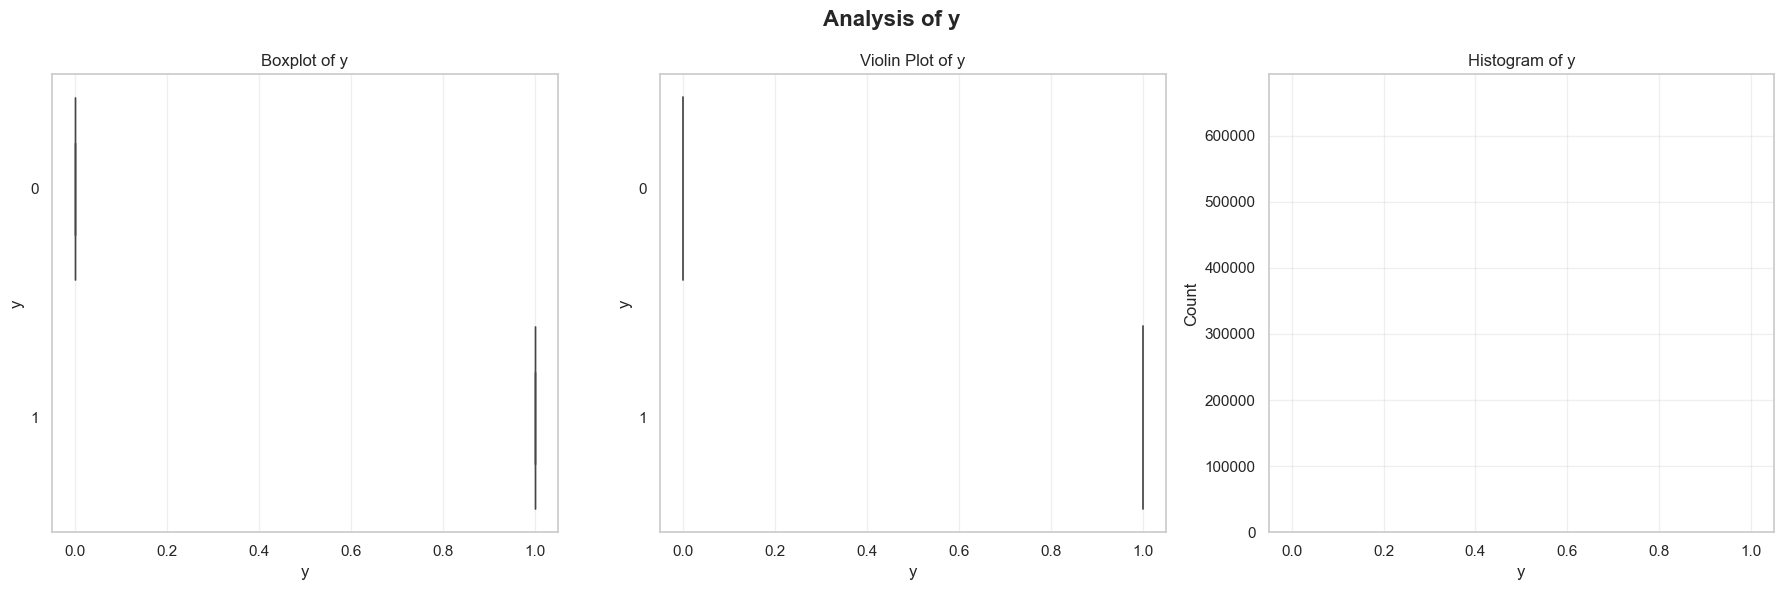

In [11]:
for feature in numerical_features:
    numerical_features_plot(train, feature, target)


### Catecorical Feature Analysis

In [12]:
def categorical_features_plot(df, feature):
    value_counts = df[feature].value_counts()

    top_n = min(10, len(value_counts))
    top_categories = value_counts.nlargest(top_n)

    df_plot = df[df[feature].isin(top_categories.index)]

    top_percentages = (top_categories / len(df)) * 100

    plt.figure(figsize=(25, 6))

    plt.subplot(1, 2, 1)
    sns.countplot(x=feature, data=df_plot, palette=sns.color_palette('viridis'))
    plt.title(f"Count Plot of {(' Top ' + str(top_n)) if len(value_counts) > top_n else ''} Categories", fontweight='bold', size=16)

    plt.subplot(1, 2, 2)
    plt.pie(
        top_percentages,
        labels=top_percentages.index,
        autopct=lambda pct: f"{pct:.2f}%",
        pctdistance=0.75,
        startangle=90
    )
    plt.gca().add_artist(plt.Circle((0, 0), 0.5, fc='w'))
    plt.title(
        f"{('Top ' + str(top_n) + ' ') if len(value_counts) > top_n else ''}Categories as % of Full Dataset {feature}",
        size=16,
        fontweight='bold'
    )
    plt.ylabel("")

    plt.tight_layout
    plt.show()

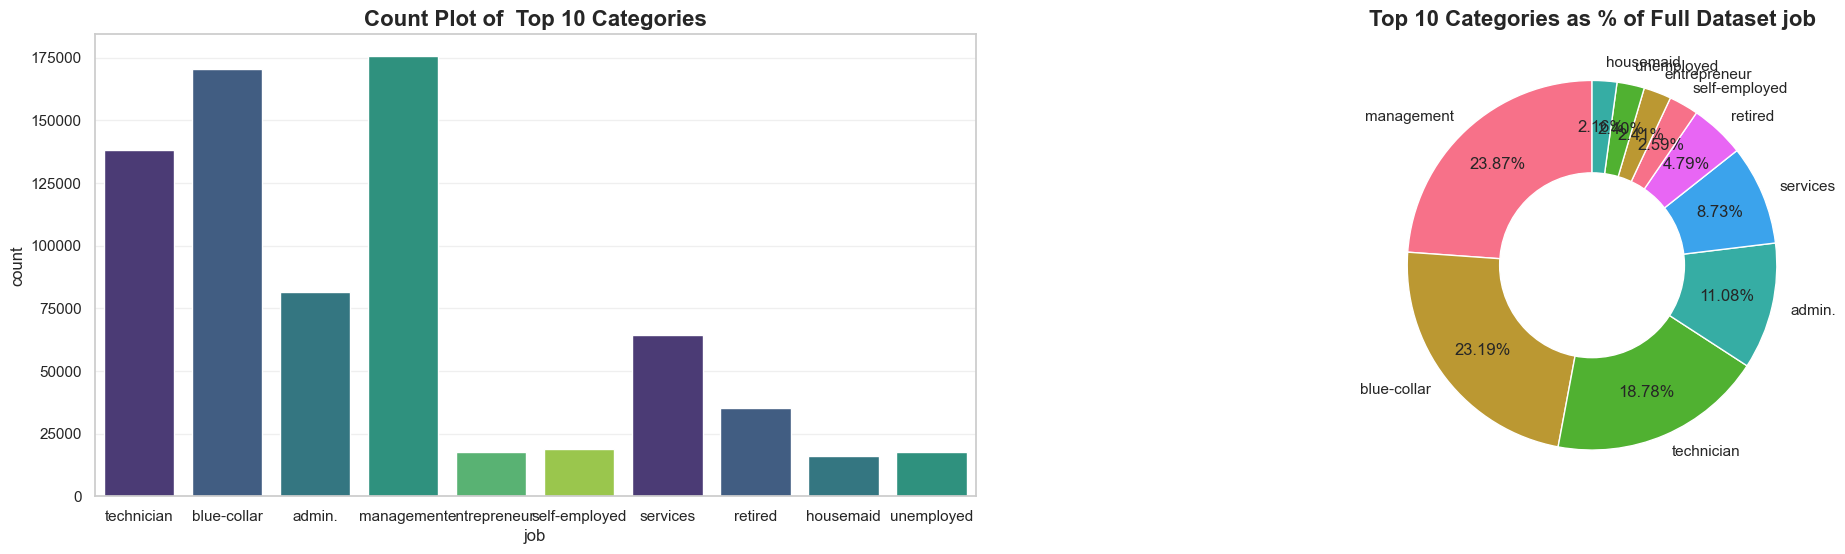

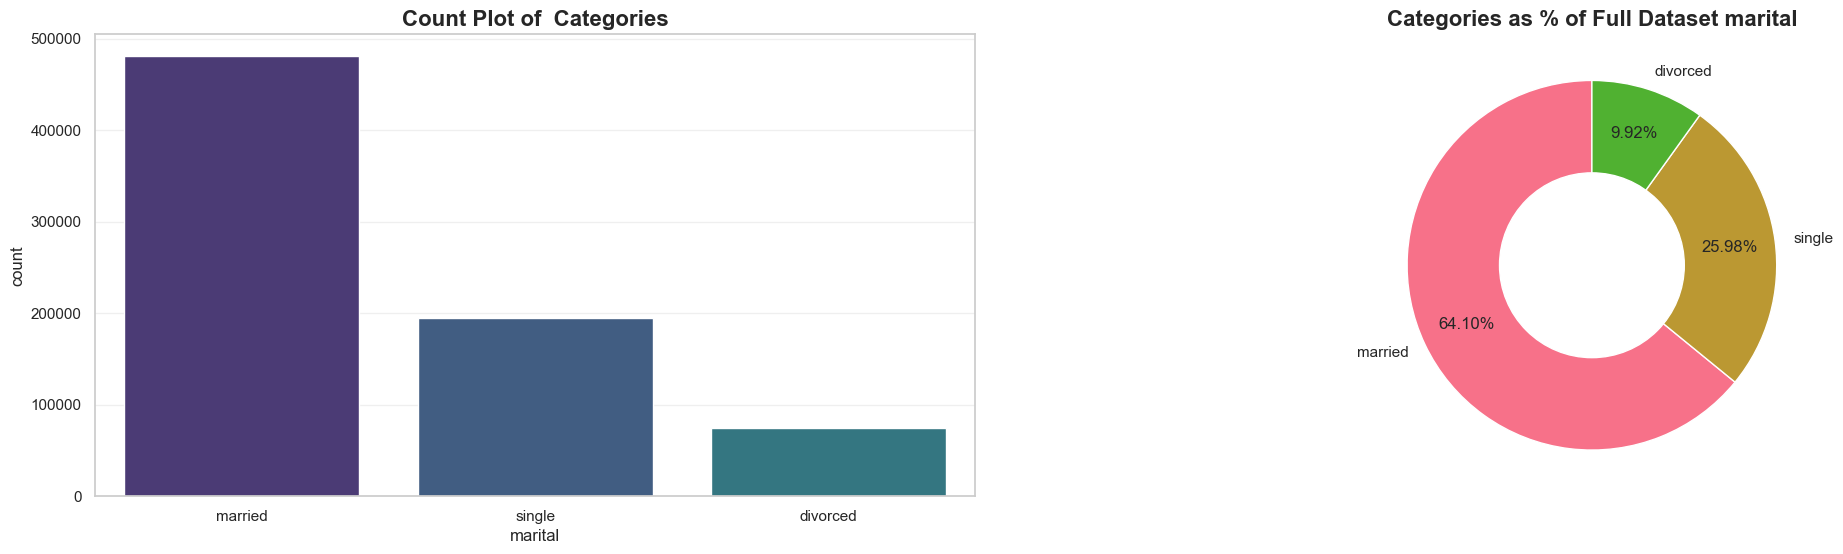

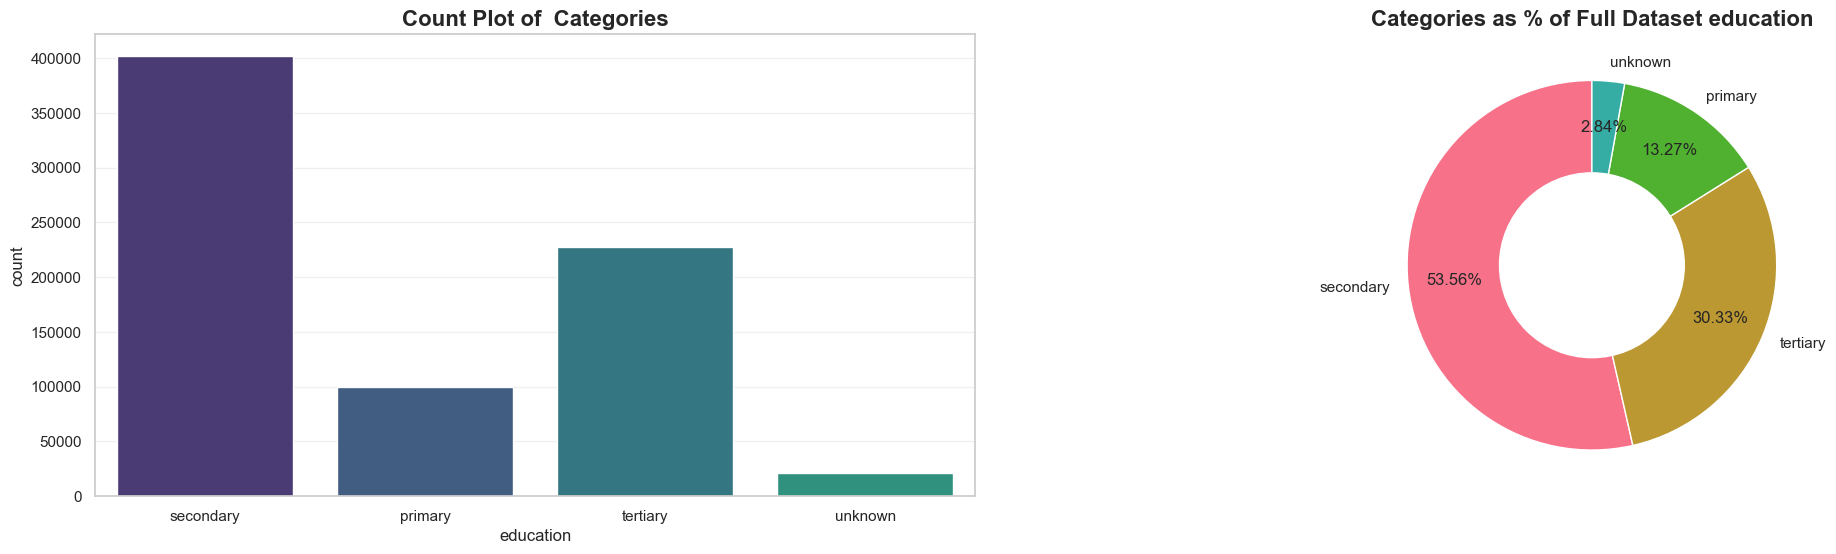

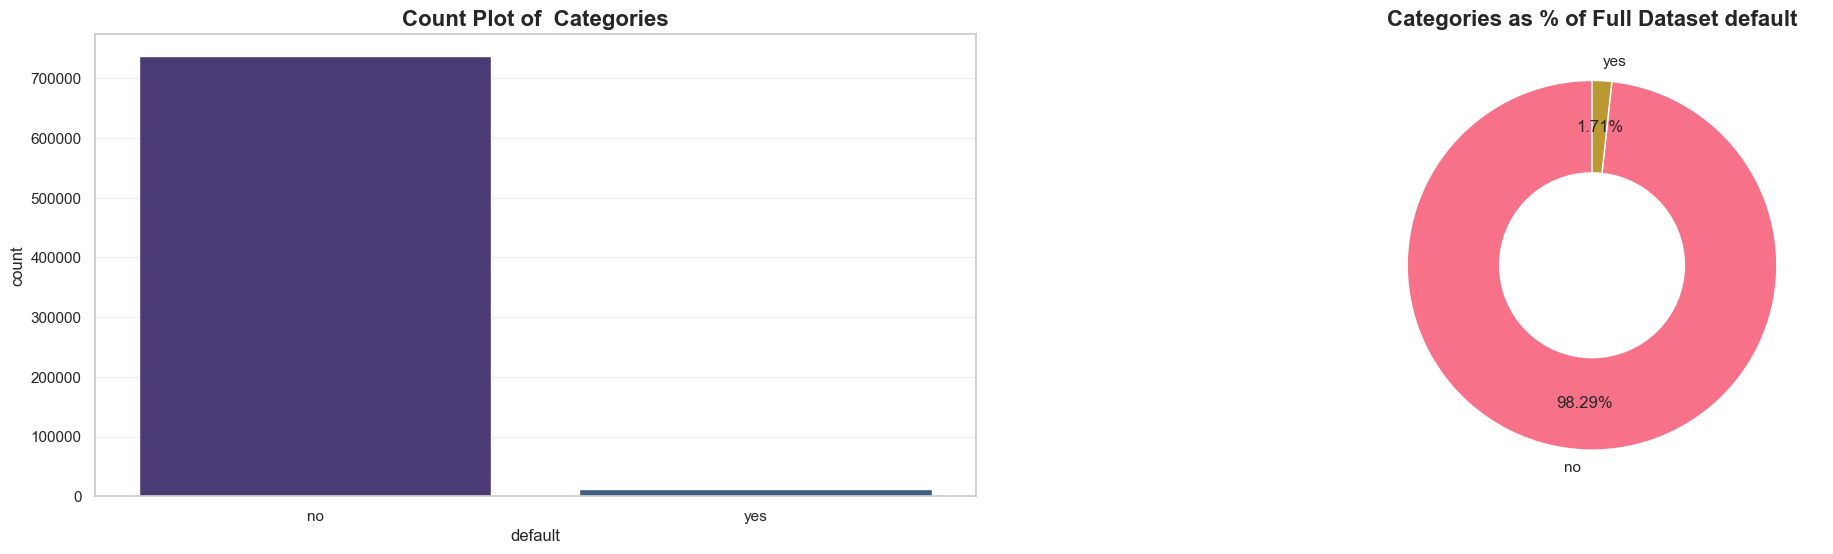

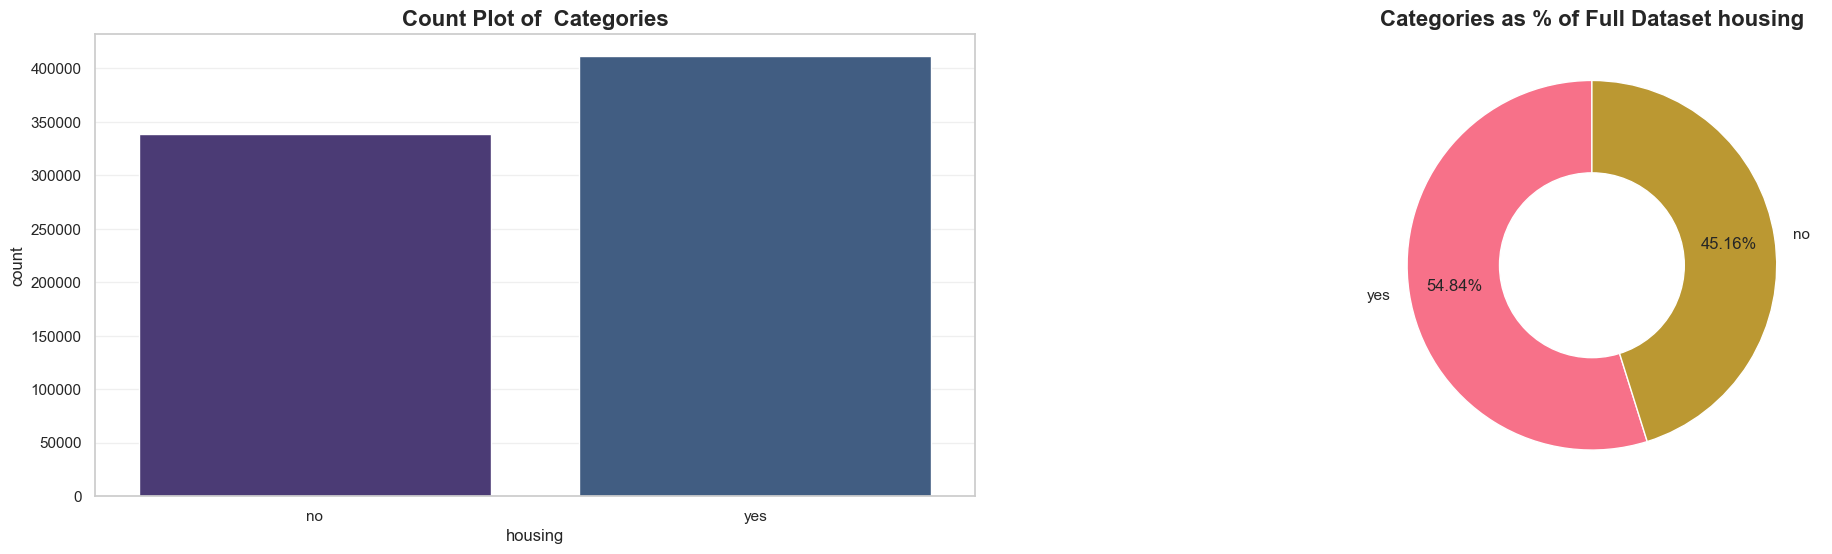

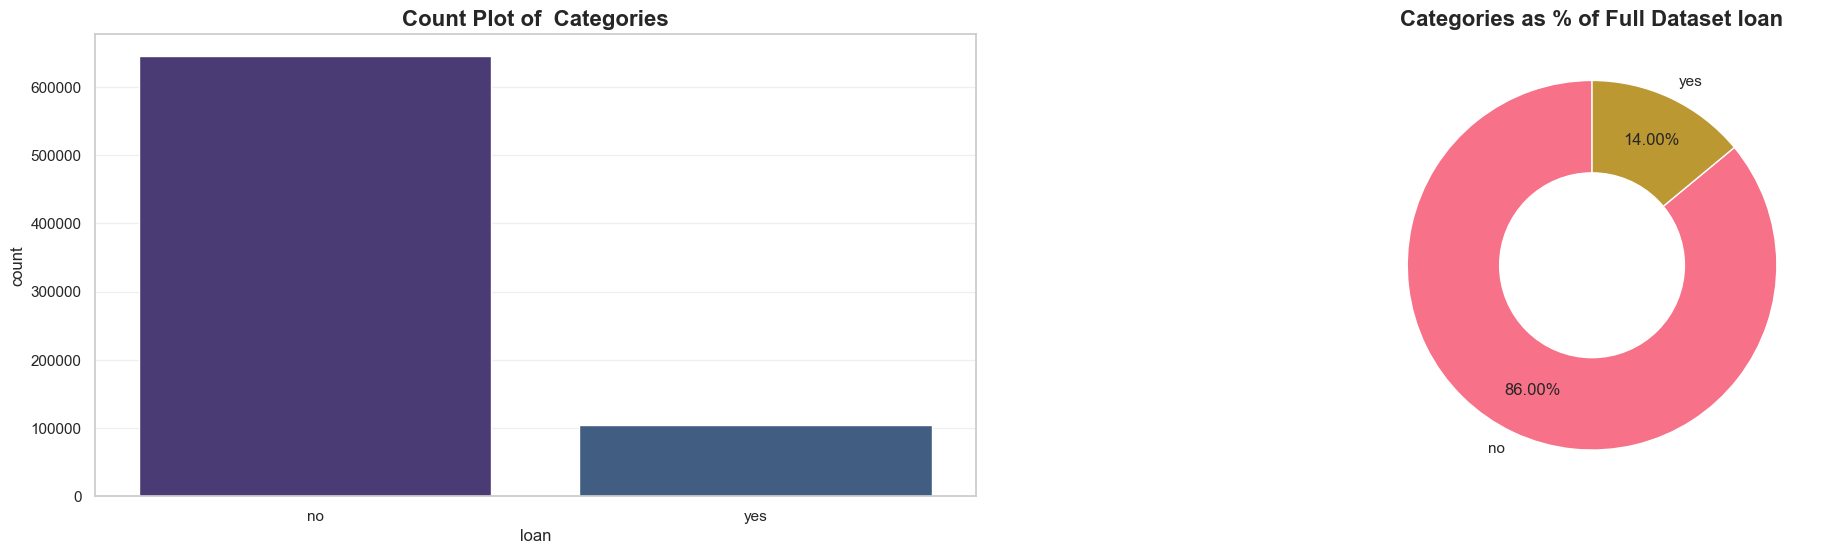

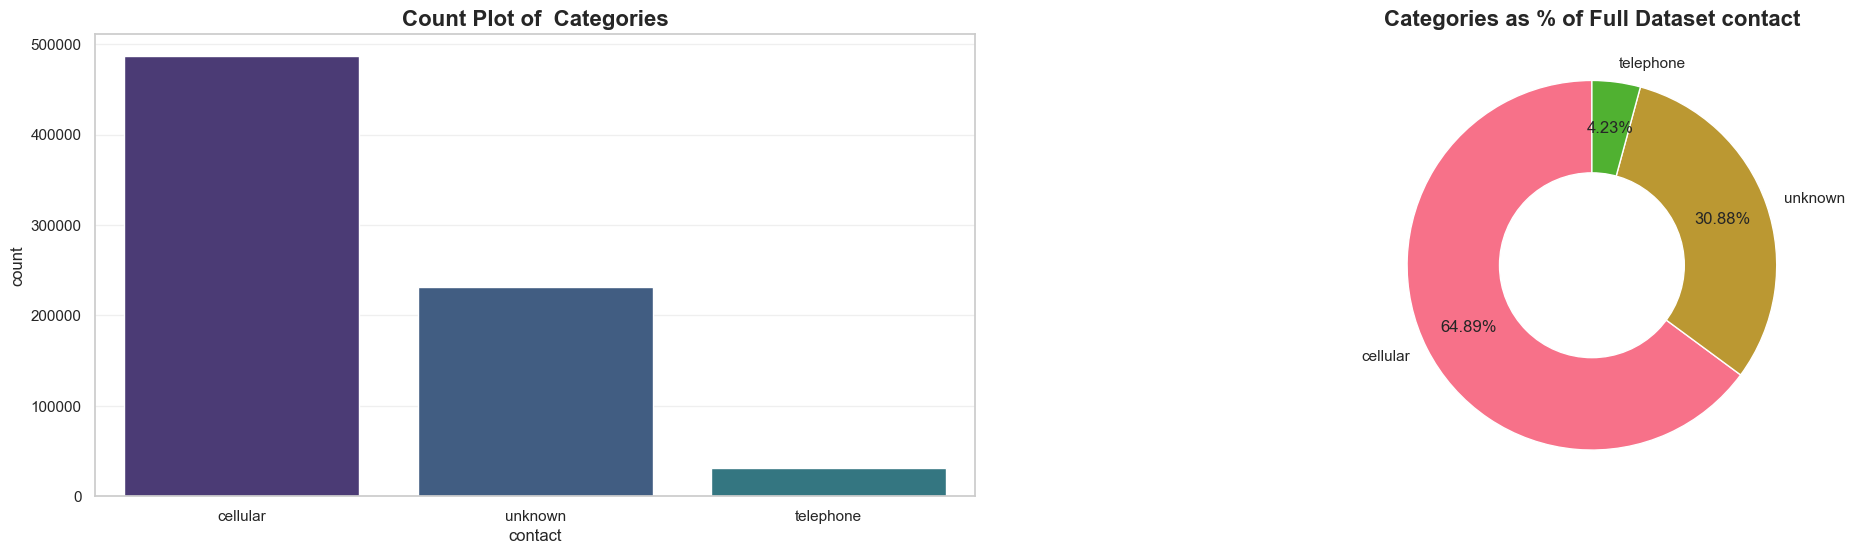

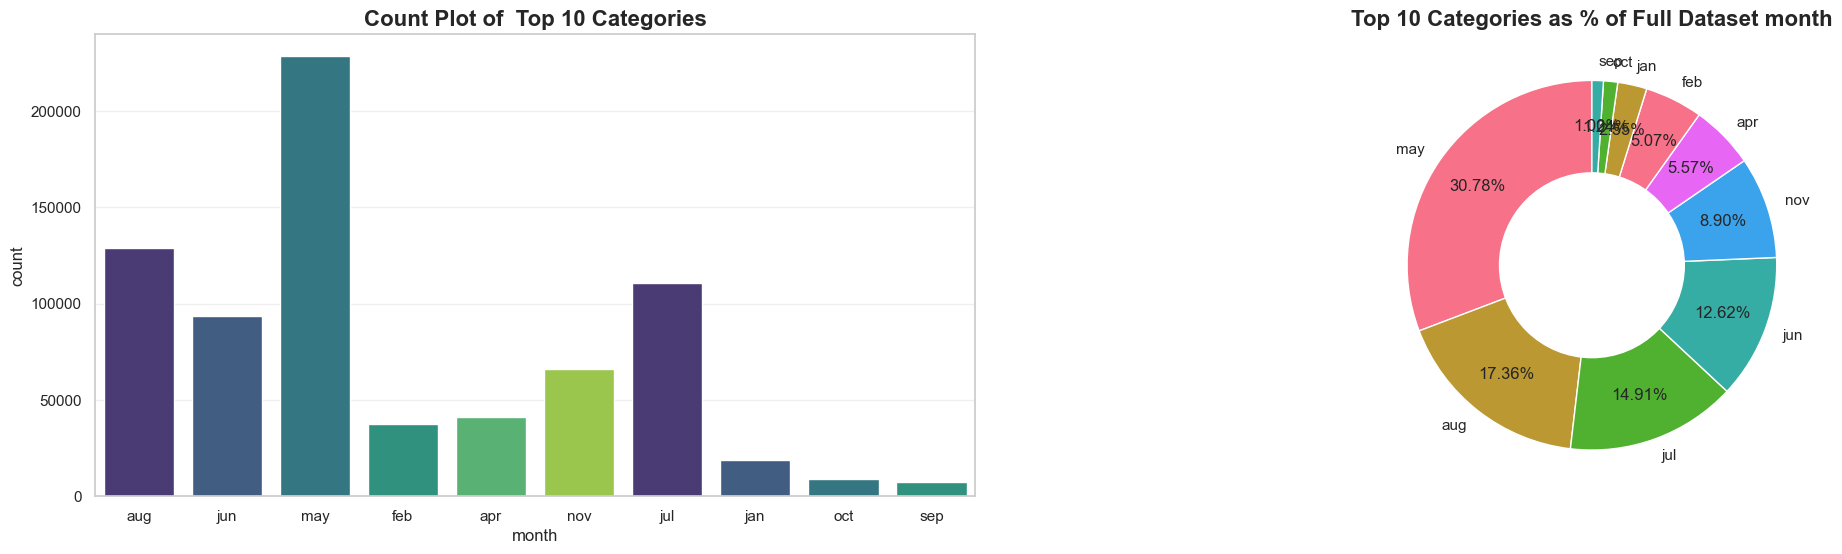

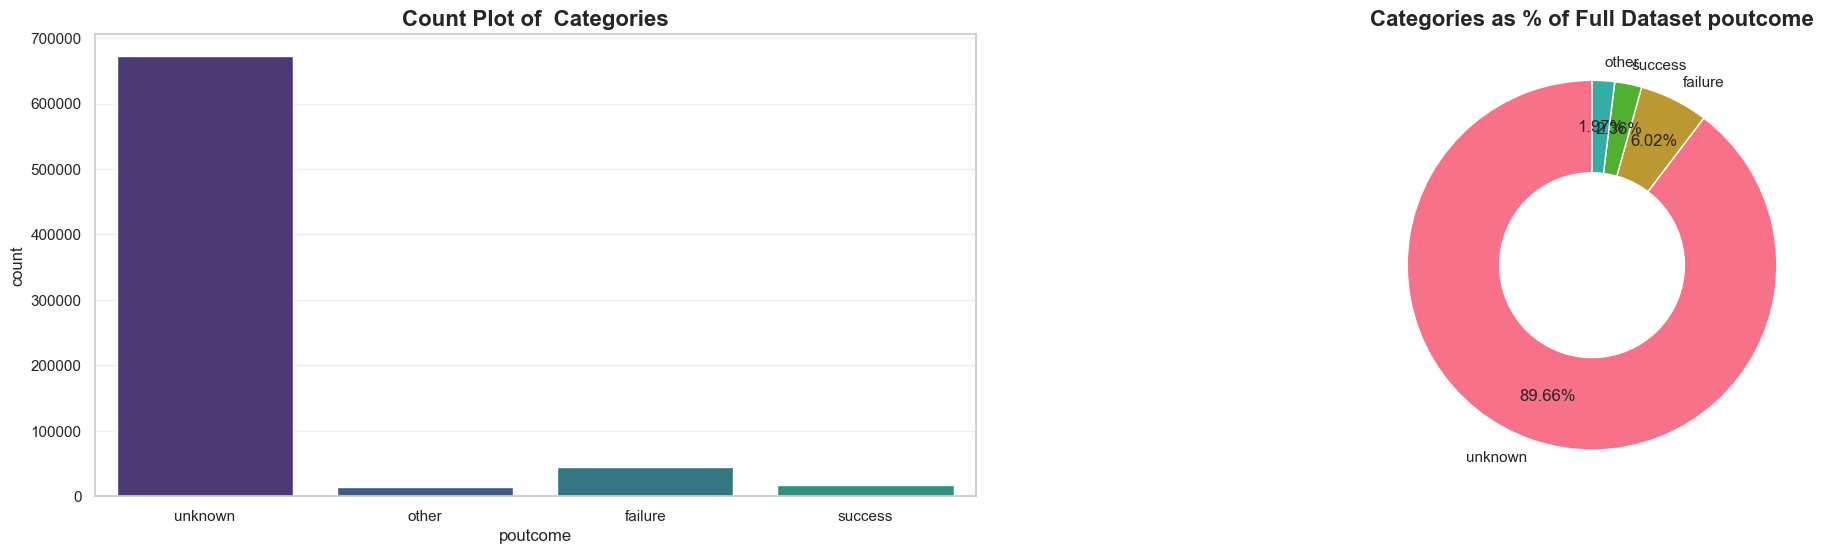

In [13]:
for feature in categorical_features:
    if feature == 'day':
        continue
    categorical_features_plot(train, feature)

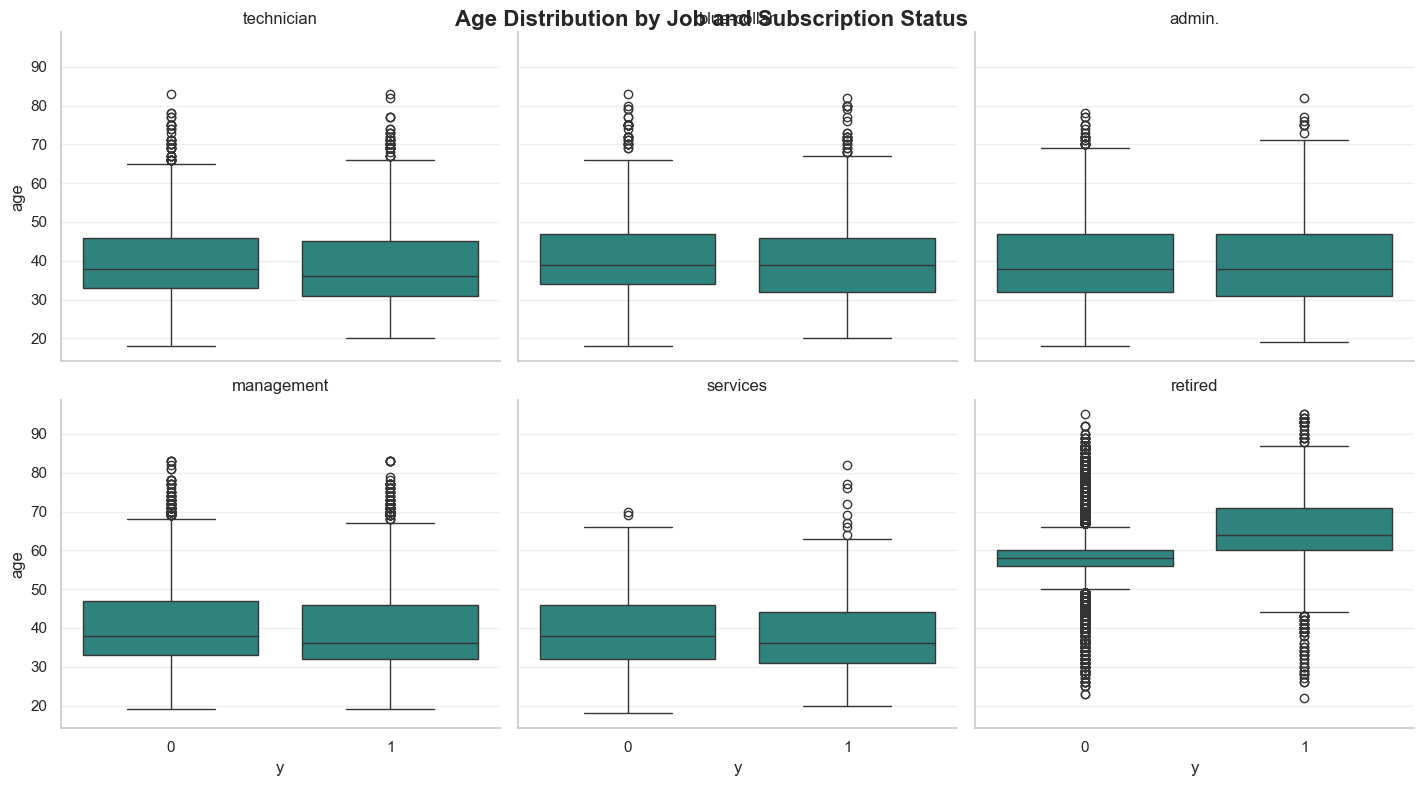

In [14]:
df = train.copy()

g = sns.FacetGrid(df[df['job'].isin(df['job'].value_counts().head(6).index)], col="job", hue=target, col_wrap=3, height=4, aspect=1.2)
g.map_dataframe(sns.boxplot, x='y', y='age', palette='viridis')
g.set_titles("{col_name}")
g.fig.suptitle('Age Distribution by Job and Subscription Status', fontsize=16, fontweight='bold')
plt.show()

In [15]:
def plot_categorical_heatmap(feature1, feature2):
    cross_tab = pd.crosstab(df[feature1], df[feature2], normalize='index') * 100
    plt.figure(figsize=(10, 6))
    sns.heatmap(cross_tab, annot=True, fmt=".1f", cmap="YlGnBu")
    plt.title(f"Heatmap of {feature1} vs {feature2}")
    plt.xlabel(feature2)
    plt.ylabel(feature1)
    plt.show()

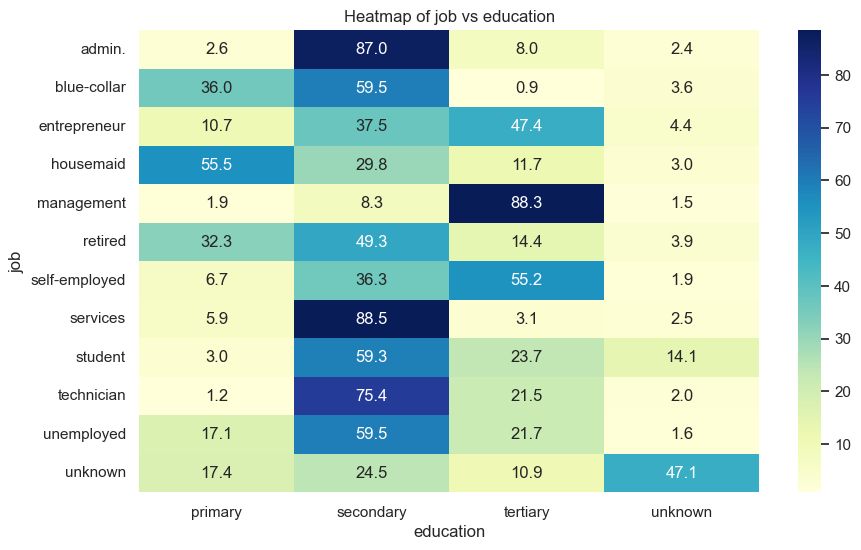

In [16]:
plot_categorical_heatmap('job', 'education')

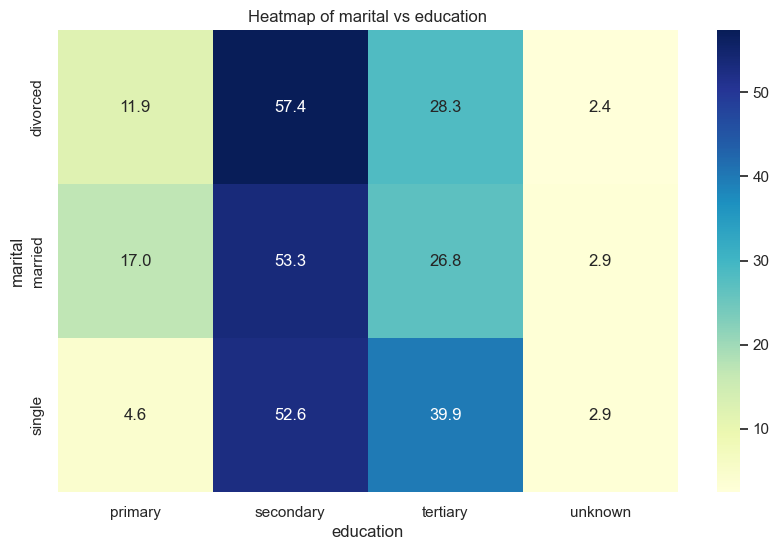

In [17]:
plot_categorical_heatmap('marital', 'education')

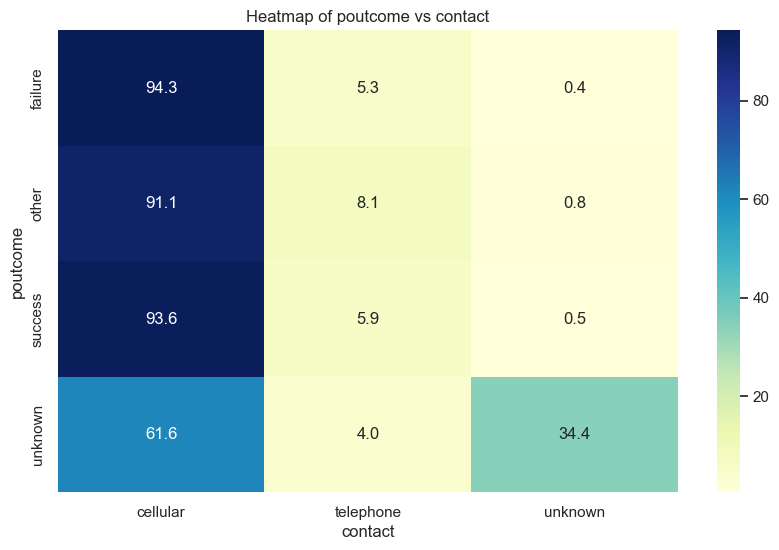

In [18]:
plot_categorical_heatmap('poutcome', 'contact')

### Model Training

In [19]:
def data_process(df):
    df = df.copy()

    def many_no(x):
        if x['default'] == 'no' and x['housing'] == 'no' and x['loan'] == 'no':
            return 21
        if x['default'] == 'no' and x['housing'] == 'no' \
        or x['default'] == 'no' and x['loan'] == 'no' \
        or x['housing'] == 'no' and x['loan'] == 'no':
            return 7
        if x['default'] == 'no' or x['housing'] == 'no' or x['loan'] == 'no':
            return 3
        return 0

    df['many_no'] = df.apply(lambda x:many_no(x), axis=1)

    return df


In [26]:
from sklearn.model_selection import train_test_split, StratifiedKFold

X = train.drop('y', axis=1)
y = train['y']

X_str = data_process(X).astype('str')
test_str = data_process(test).astype('str')

X.head()
X_str.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,many_no
id,,,,,,,,,,,,,,,,,
0,42,technician,married,secondary,no,7,no,no,cellular,25,aug,117,3,-1,0,unknown,21
1,38,blue-collar,married,secondary,no,514,no,no,unknown,18,jun,185,1,-1,0,unknown,21
2,36,blue-collar,married,secondary,no,602,yes,no,unknown,14,may,111,2,-1,0,unknown,7
3,27,student,single,secondary,no,34,yes,no,unknown,28,may,10,2,-1,0,unknown,7
4,26,technician,married,secondary,no,889,yes,no,cellular,3,feb,902,1,-1,0,unknown,7


In [ ]:
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score
from sklearn.base import clone
from tqdm import tqdm

cat_clf = CatBoostClassifier(
    allow_writing_files=False,
    verbose=0,
    #task_type = 'GPU'
    loss_function='CrossEntropy',
    use_best_model=True,
    cat_features=X_str.columns.to_list(),
    n_estimators=1000,
    learning_rate=0.1
)

N_SPLITS = 5
skfold = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)
test_pred = np.zeros(len(test_str))
roc_scores = []

for fold, (train_idx, test_idx) in enumerate(tqdm(skfold.split(X_str, y))):
    print(f"Training fold {fold + 1}/{N_SPLITS}...")
    X_train, X_val = X_str.iloc[train_idx], X_str.iloc[test_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[test_idx]

    model = clone(cat_clf)
    model.fit(
        X_train, y_train,
        eval_set=(X_val, y_val),
        early_stopping_rounds=200
    )

    y_pred = model.predict_proba(X_val)[:, 1]
    roc_score = roc_auc_score(y_val, y_pred)
    roc_scores.append(roc_score)
    print(f"Fold {fold + 1} ROC AUC: {roc_score:.4f}")

    test_pred += model.predict_proba(test_str)[:, 1]

print(f"Average Fold ROC AUC: {np.mean(roc_scores):.4f} \xb1 {np.std(roc_scores):.4f}")

test_pred = test_pred / N_SPLITS

0it [00:00, ?it/s]

Training fold 1/5...


0it [05:10, ?it/s]


KeyboardInterrupt: 

### Submission

In [25]:
sub = pd.read_csv('../data/inputs/sample_submission.csv', index_col='id')
sub['y'] = test_pred
sub.to_csv('../data/outputs/submission.csv', index=False)
sub.head()

,y
id,
750000,0.0
750001,0.0
750002,0.0
750003,0.0
750004,0.0
